In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import statistics as st
from datetime import datetime

In [152]:
model_path_LSTM = "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20241029/WARS/WARS_fh8_u_total_HRRR_ml_output_linear.parquet"

In [153]:
station = "WARS"
fh = 12

In [154]:
full_df = pd.read_parquet(
    "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20241029/WARS/10_29_2024_00:41:21_full_WARS.parquet"
)

In [155]:
lookup_path = "/home/aevans/nwp_bias/src/machine_learning/data/parent_models/HRRR/s2s/Central Lakes_t2m_HRRR_lookup_linear.csv"

lookup_path_quad = "/home/aevans/nwp_bias/src/machine_learning/data/parent_models/HRRR/s2s/Central Lakes_t2m_HRRR_lookup_quad.csv"

In [156]:
ldf = pd.read_parquet(model_path_LSTM)
# ldf = ldf.sort_index()
# ldf['Model forecast'] = ldf['Model forecast']*-1

In [157]:
ldf

,target_error_lead_0,Model forecast,diff,valid_time
0,-0.090920,-2812.620850,0.006747,2018-01-01 08:00:00
1,0.100103,-2812.620850,-0.003678,2018-01-01 09:00:00
2,-0.416165,-2812.620850,-0.551070,2018-01-01 10:00:00
3,-0.047151,-2812.620850,-0.138603,2018-01-01 11:00:00
4,0.381637,-2812.620850,0.353771,2018-01-01 12:00:00
...,...,...,...,...
45605,0.016103,-0.151369,-0.243956,2023-12-31 19:00:00
45606,0.258149,-0.102691,-0.001996,2023-12-31 20:00:00
45607,0.326037,-0.003826,0.065807,2023-12-31 21:00:00
45608,-0.057512,0.058478,-0.317821,2023-12-31 22:00:00


In [158]:
full_df.dropna(inplace=True)
full_df

,valid_time_cos,valid_time_sin,target_error,valid_time,t2m_WARS,sh2_WARS,d2m_WARS,r2_WARS,u10_WARS,v10_WARS,...,relh_EAUR,srad_EAUR,pres_EAUR,mslp_EAUR,wspd_sonic_mean_EAUR,wspd_sonic_EAUR,wmax_sonic_EAUR,wdir_sonic_EAUR,snow_depth_EAUR,precip_total_EAUR
0,0.999853,0.017166,1.773721,2018-01-01 01:00:00,-18.781439,0.00074,-21.042487,78.699997,4.409807,-0.192684,...,83.770439,0.000087,982.019226,988.392212,1.855067,1.895088,2.114592,181.731094,0.284939,0.000000
1,0.999853,0.017166,1.983799,2018-01-01 02:00:00,-19.718268,0.00066,-22.234091,75.500000,4.332315,0.323778,...,82.819168,0.000000,981.700806,987.904846,1.987436,1.898009,2.224869,188.282806,0.289150,0.000000
2,0.999853,0.017166,1.911640,2018-01-01 03:00:00,-19.526526,0.00064,-22.627554,70.800003,4.210405,1.018774,...,80.555771,0.000000,981.920776,988.125610,1.439727,1.605573,1.998764,188.708496,0.294875,0.000000
3,0.999853,0.017166,1.729052,2018-01-01 04:00:00,-19.202429,0.00064,-22.628439,69.500000,4.537243,1.624184,...,81.073929,0.000000,982.096375,987.653442,1.369325,1.229874,2.229875,233.004303,0.290689,0.000000
4,0.999853,0.017166,1.397139,2018-01-01 05:00:00,-20.046729,0.00064,-22.761481,73.900002,4.264832,0.636243,...,82.228249,0.000000,982.099609,987.873047,1.550213,1.754455,2.322508,225.193207,0.292096,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45655,0.999853,-0.017166,1.794031,2023-12-31 19:00:00,0.362451,0.00342,-2.134070,84.000000,1.913271,1.902529,...,85.060280,55.330387,967.785889,969.676270,1.556281,1.067297,1.517025,244.100494,-0.001395,0.000000
45656,0.999853,-0.017166,2.180462,2023-12-31 20:00:00,0.762811,0.00342,-2.090338,80.800003,2.902524,0.263618,...,83.284767,31.108330,967.987488,969.878174,1.554884,2.111480,3.640032,222.906204,-0.002432,0.000000
45657,0.999853,-0.017166,2.087902,2023-12-31 21:00:00,0.577661,0.00344,-2.025214,82.500000,2.473973,-0.305409,...,86.678436,5.745638,968.008423,969.932861,1.452541,1.376039,2.337798,189.447601,-0.002751,0.000000
45658,0.999853,-0.017166,-0.408249,2023-12-31 22:00:00,-0.153357,0.00362,-1.337714,91.500000,0.262230,-0.888440,...,89.961983,0.613300,968.289124,970.257568,1.250894,1.809462,2.564407,186.295898,-0.002918,0.000000


In [159]:
for k in full_df.keys():
    print(k)

valid_time_cos
valid_time_sin
target_error
valid_time
t2m_WARS
sh2_WARS
d2m_WARS
r2_WARS
u10_WARS
v10_WARS
tp_WARS
mslma_WARS
tcc_WARS
asnow_WARS
cape_WARS
dswrf_WARS
dlwrf_WARS
gh_WARS
u_total_WARS
u_dir_WARS
lulc_cat_WARS
elev_cat_WARS
slope_cat_WARS
t2m_BATA
sh2_BATA
d2m_BATA
r2_BATA
u10_BATA
v10_BATA
tp_BATA
mslma_BATA
tcc_BATA
asnow_BATA
cape_BATA
dswrf_BATA
dlwrf_BATA
gh_BATA
u_total_BATA
u_dir_BATA
lulc_cat_BATA
elev_cat_BATA
slope_cat_BATA
t2m_YORK
sh2_YORK
d2m_YORK
r2_YORK
u10_YORK
v10_YORK
tp_YORK
mslma_YORK
tcc_YORK
asnow_YORK
cape_YORK
dswrf_YORK
dlwrf_YORK
gh_YORK
u_total_YORK
u_dir_YORK
lulc_cat_YORK
elev_cat_YORK
slope_cat_YORK
t2m_EAUR
sh2_EAUR
d2m_EAUR
r2_EAUR
u10_EAUR
v10_EAUR
tp_EAUR
mslma_EAUR
tcc_EAUR
asnow_EAUR
cape_EAUR
dswrf_EAUR
dlwrf_EAUR
gh_EAUR
u_total_EAUR
u_dir_EAUR
lulc_cat_EAUR
elev_cat_EAUR
slope_cat_EAUR
lat_WARS
lon_WARS
elev_WARS
tair_WARS
ta9m_WARS
td_WARS
relh_WARS
srad_WARS
pres_WARS
mslp_WARS
wspd_sonic_mean_WARS
wspd_sonic_WARS
wmax_sonic_WARS
w

In [160]:
# ldf["valid_time"] = full_df["valid_time"]

In [161]:
def which_fold(df, fold):
    length = len(df)
    test_len = int(length * 0.2)
    df_train = pd.DataFrame()

    for n in np.arange(0, 5):
        if n != fold:
            df1 = df.iloc[int(0.2 * n * length) : int(0.2 * (n + 1) * length)]
            df_train = pd.concat([df_train, df1])
        else:
            df_test = df.iloc[int(0.2 * n * length) : int(0.2 * (n + 1) * length)]
            f = int(len(df_test) * 0.5)
            df_val = df_test.iloc[:f]
            df_test = df_test[-f:]

    return df_train["valid_time"], df_test["valid_time"], df_val["valid_time"]

In [162]:
ldf["valid_time"] = pd.to_datetime(ldf["valid_time"])

In [163]:
df_train, df_test, df_val = which_fold(ldf, 4)

In [164]:
test_set_start = df_test.iloc[0]
test_set_start

Timestamp('2023-06-23 14:00:00')

In [165]:
test_set_finish = df_test.iloc[-1]
test_set_finish

Timestamp('2023-12-31 23:00:00')

In [166]:
df_val.iloc[0]

Timestamp('2022-11-18 03:00:00')

In [167]:
df_val.iloc[-1]

Timestamp('2023-06-23 13:00:00')

In [168]:
def date_filter(ldf, time1, time2):
    ldf = ldf[ldf["valid_time"] > time1]
    ldf = ldf[ldf["valid_time"] < time2]

    return ldf

## Time filter 

In [169]:
time1 = datetime(2023, 6, 1, 0, 0, 0)
time2 = datetime(2023, 6, 30, 23, 0, 0)

ldf = date_filter(ldf, time1, time2)
full_df = date_filter(full_df, time1, time2)

In [170]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def create_heatmap(df, x_column="target_error_lead_0", y_column="Model forecast"):
    # Round values
    df[x_column] = np.round(df[x_column] / 1.0) * 1.0
    df[y_column] = np.round(df[y_column] / 1.0) * 1.0

    # Pivot the DataFrame to create a matrix suitable for the heatmap
    heatmap_data = pd.pivot_table(
        df, index=y_column, columns=x_column, aggfunc="size", fill_value=0
    )

    # Calculate percentages
    total = heatmap_data.sum()
    heatmap_data_percent = (heatmap_data / total) * 100

    # Create the heatmap using seaborn
    plt.figure(figsize=(16, 12))
    sns.heatmap(
        heatmap_data_percent,
        vmax=100,
        cmap="Reds",
        annot=True,
        fmt=".1f",  # Format as percentage with one decimal place
        cbar_kws={"label": "Percentage (%)"},  # Add color bar label
    )

    # Set the labels and title
    plt.xlabel("Target")
    plt.ylabel("LSTM")
    plt.title("Heatmap of Target vs LSTM")

    # Show the heatmap
    plt.show()

In [171]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde


def create_scatterplot(df, x_column="target_error_lead_0", y_column="Model forecast"):
    # Calculate point density
    xy = np.vstack([df[x_column], df[y_column]])
    z = gaussian_kde(xy)(xy)

    plt.figure(figsize=(8, 8))

    # Create the scatterplot
    scatter = plt.scatter(
        df[x_column],
        df[y_column],
        c=z,
        cmap="YlOrRd",
        s=100,
        edgecolor="black",
        alpha=0.3,
    )

    # Add color bar with label
    cbar = plt.colorbar(scatter)
    cbar.set_label("Point Density")

    # Set labels and title
    plt.xlabel("Target", fontsize=18)
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    plt.ylabel("LSTM", fontsize=18)
    plt.title("Scatterplot with Density and Colorbar", fontsize=24)

    # Show the plot
    plt.show()

In [172]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


def create_scatterplot_heatmap(
    df, x_column="target_error_lead_0", y_column="Model forecast", gridsize=100
):
    plt.figure(figsize=(16, 12))

    # Create a 2D histogram (binning) to calculate point concentration
    hb = plt.hexbin(
        df[x_column], df[y_column], gridsize=gridsize, cmap="viridis", mincnt=1
    )

    # Add color bar with label
    cbar = plt.colorbar(hb)
    cbar.set_label("Number of Points")

    # Set labels and title
    plt.xlabel("Target", fontsize=18)
    plt.ylabel("LSTM", fontsize=18)
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    plt.title("Scatterplot Heatmap with Point Frequency", fontsize=24)

    # Show the plot
    plt.show()

In [173]:
import matplotlib.pyplot as plt
import numpy as np


def create_hexbin_heatmap(
    df, x_column="target_error_lead_0", y_column="Model forecast"
):
    plt.figure(figsize=(16, 12))

    # Create hexbin plot with continuous color density
    hexplot = plt.hexbin(
        df[x_column], df[y_column], gridsize=50, cmap="cividis", mincnt=1
    )

    # Add color bar with label
    cbar = plt.colorbar(hexplot)
    cbar.set_label("Count in Bin")

    # Set labels and title
    plt.xlabel("Target", fontsize=18)
    plt.ylabel("LSTM", fontsize=18)
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    plt.title("Hexbin Scatterplot Heatmap with Colorbar", fontsize=24)

    # Show the plot
    plt.show()

In [174]:
def quantile_regression(x, y):
    X = x[:, np.newaxis]
    quantiles = [0.10, 0.5, 0.90]
    predictions = {}
    out_bounds_predictions = np.zeros_like(y, dtype=np.bool_)
    for quantile in quantiles:
        qr = QuantileRegressor(quantile=quantile, alpha=0, solver=solver)
        y_pred = qr.fit(X, y).predict(X)
        predictions[quantile] = y_pred

    predictions_df = pd.DataFrame()
    predictions_df["target"] = x

    for q in quantiles:
        predictions_df[q] = predictions.get(q)

    return qr, y_pred, predictions_df

In [175]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np


def ml_output(df, full_df, fold, station, test_set_start, test_set_finish, fh):
    fig, ax = plt.subplots(figsize=(24, 6))
    x = df["valid_time"]

    # Convert datetime values to numerical values
    x_numeric = mdates.date2num(x)

    # Assuming your timestamps are in a datetime64 format
    day_mask = (x.dt.hour >= 6) & (
        x.dt.hour < 18
    )  # Adjust the hours based on your day/night definition

    plt.plot(
        np.array(x),
        np.array(df["target_error_lead_0"]),
        c="black",
        linewidth=1,
        label="Target",
    )

    plt.plot(
        np.array(x),
        np.array(df["Model forecast"]),
        c="red",
        linewidth=3,
        alpha=0.7,
        label="LSTM Output",
    )

    # plt.axvline(
    #     x=test_set_start,
    #     c="green",
    #     linestyle="--",
    #     linewidth=2.0,
    #     label="Test Set Start",
    # )
    # plt.axvline(
    #     x=test_set_finish,
    #     c="red",
    #     linestyle="--",
    #     linewidth=2.0,
    #     label="Test Set Finish",
    # )

    # Fill daytime hours with white color
    ax.fill_between(
        x_numeric, -4, 4.1, where=day_mask, color="white", alpha=0.5, label="Daytime"
    )

    # Fill nighttime hours with grey color
    ax.fill_between(
        x_numeric, -4, 4.1, where=~day_mask, color="grey", alpha=0.2, label="Nighttime"
    )

    ax.set_title(f"Wind Error LSTM Output v Target: {station}: FH{fh}", fontsize=28)
    # plt.ylim(-5, 5.)
    ax.legend()

    plt.show()

In [176]:
def find_linear_coefficients(df):
    """
    Adjusts the 'Model forecast' column of the input DataFrame by aligning it with
    the statistics of the 'target_error_lead_0' column. The alignment involves
    subtracting the difference in means and scaling based on the maximum absolute values
    of both columns. The result is that the 'Model forecast' is transformed to better fit
    the target error profile.

    Parameters:
    df (pandas.DataFrame): Input DataFrame with 'target_error_lead_0' and 'Model forecast' columns.

    Returns:
    pandas.DataFrame: The modified DataFrame with updated 'Model forecast' values.
    """

    # Calculate the mean of 'target_error_lead_0' and 'Model forecast'
    mean1 = st.mean(df["target_error_lead_0"])
    mean2 = st.mean(df["Model forecast"])

    # Find the row with the maximum absolute value in 'target_error_lead_0'
    max1_index = df["target_error_lead_0"].abs().idxmax()
    # Retrieve the row that contains this maximum absolute value
    max_row = df.loc[max1_index]

    # Find the row with the maximum absolute value in 'target_error_lead_0'
    min1_index = df["target_error_lead_0"].abs().idxmin()
    # Retrieve the row that contains this maximum absolute value
    min_row = df.loc[min1_index]

    # Find the maximum absolute value of 'target_error_lead_0' and 'Model forecast'
    max1 = abs(max_row["target_error_lead_0"])
    max2 = abs(max_row["Model forecast"])

    # Find the maximum absolute value of 'target_error_lead_0' and 'Model forecast'
    min1 = abs(min_row["target_error_lead_0"])
    min2 = abs(min_row["Model forecast"])

    # Calculate the difference in means between 'Model forecast' and 'target_error_lead_0'
    diff = mean2 - mean1

    # # Recalculate the maximum absolute value after adjustment
    # max1 = abs(max(df['target_error_lead_0']))
    # max2 = abs(max(df['Model forecast']))

    # Scale the 'Model forecast' by the ratio of maximum absolute values
    multiply1 = max1 / max2

    multiply2 = min1 / min2

    multiply = (multiply1 + multiply2) / 2.0

    # Return the modified DataFrame
    return diff, multiply

In [177]:
def refit_output(df, diff, multiply):
    # Adjust the 'Model forecast' by subtracting the difference in means
    df["Model forecast"] = df["Model forecast"] - diff
    df["Model forecast"] = df["Model forecast"] * multiply

    # Calculate the median of 'target_error_lead_0' and 'Model forecast'
    mean3 = st.median(df["target_error_lead_0"])
    mean4 = st.median(df["Model forecast"])

    # Center both 'target_error_lead_0' and 'Model forecast' by subtracting their medians
    df["target_error_lead_0"] = df["target_error_lead_0"] - mean3
    df["Model forecast"] = df["Model forecast"] - mean4

    return df

In [178]:
def refit_output_quad(df, a, b, c):
    quadratic_fit = np.poly1d([a, b, c])
    # adjust total model output
    adjusted_lstm_output = df_out["Model forecast"] + quadratic_fit(
        df_out["Model forecast"]
    )
    df_out["Model forecast"] = adjusted_lstm_output

    # Calculate the median of 'target_error_lead_0' and 'Model forecast'
    mean3 = st.median(df["target_error_lead_0"])
    mean4 = st.median(df["Model forecast"])

    # Center both 'target_error_lead_0' and 'Model forecast' by subtracting their medians
    df["target_error_lead_0"] = df["target_error_lead_0"] - mean3
    df["Model forecast"] = df["Model forecast"] - mean4

    return df

In [179]:
def get_alpha_diff_from_lookup(ldf, lookup_path, station, fh):
    lookup = pd.read_csv(lookup_path)
    lookup = lookup[lookup["station"] == station]
    lookup = lookup[lookup["forecast_hour"] == fh]

    alpha = lookup["alpha"].values
    diff = lookup["diff"].values

    return alpha, diff

In [180]:
def get_alpha_beta_charli_from_lookup(ldf, lookup_path, station, fh):
    lookup = pd.read_csv(lookup_path)
    lookup = lookup[lookup["station"] == station]
    lookup = lookup[lookup["forecast_hour"] == fh]

    alpha = lookup["alpha"].values
    beta = lookup["beta"].values
    charli = lookup["charli"].values

    return alpha, beta, charli

In [181]:
# alpha, diff = get_alpha_diff_from_lookup(ldf, lookup_path, station, fh)

In [182]:
# a, b, c = get_alpha_beta_charli_from_lookup(ldf, lookup_path_quad, station, fh)

In [183]:
# ldf_linear = refit_output(ldf, alpha, diff)

In [184]:
# ldf_quad = refit_output_quad(ldf, a, b, c)

In [185]:
# ldf_linear["diff"] = ldf_linear.iloc[:, 0] - ldf_linear.iloc[:, 1]
# ldf_quad["diff"] = ldf_quad.iloc[:, 0] - ldf_quad.iloc[:, 1]

In [186]:
ldf["diff"] = ldf.iloc[:, 0] - ldf.iloc[:, 1]

In [187]:
mean = st.mean(abs(ldf["diff"]))
mean

0.5186351933054157

In [188]:
mean_s = st.mean(ldf["diff"] ** 2)
mean_s

0.40684383847910205

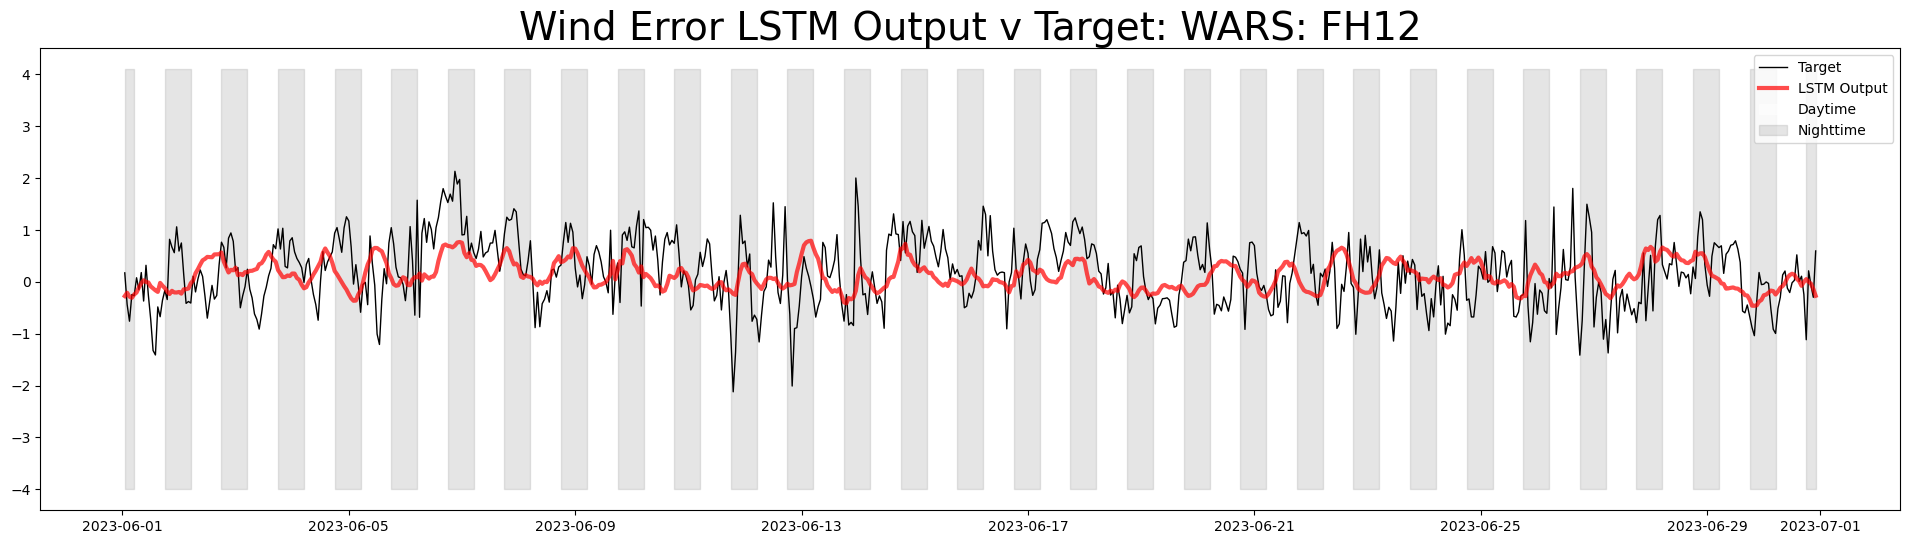

In [189]:
x = ml_output(ldf, full_df, 4, station, test_set_start, test_set_finish, fh)

In [190]:
# mean = st.mean(abs(ldf_quad["diff"]))
# mean

In [191]:
# mean_s = st.mean(ldf_quad["diff"] ** 2)
# mean_s

In [192]:
# x = ml_output(ldf_quad, full_df, 4, station, test_set_start, test_set_finish, fh)

In [193]:
for k in full_df.columns:
    if re.search(
        f"{station}|valid|Model forecast|Abs_err",
        k,
    ):
        continue
    else:
        full_df = full_df.drop(columns=[k])

In [194]:
# test_len = int(len(full_df['valid_time'])*0.2)
# full_df = full_df.iloc[0:test_len]

In [195]:
def groupby_month(df, col):
    df = df[df[col] > -999]
    GB = df.groupby([(df.valid_time.dt.month), (df.valid_time.dt.year)])[col].mean()
    the_list = GB.tolist()
    fig, ax = plt.subplots(figsize=(21, 6))
    x = np.arange(1, len(the_list) + 1)
    plt.bar(x, the_list)
    ax.set_xticklabels([2018, 2019, 2020, 2021, 2022, 2023])
    ax.set_xticks(np.arange(1, len(the_list) + 1, int((len(the_list) + 1) / 6)))
    return the_list

In [196]:
full_df.head()

,valid_time_cos,valid_time_sin,valid_time,t2m_WARS,sh2_WARS,d2m_WARS,r2_WARS,u10_WARS,v10_WARS,tp_WARS,...,relh_WARS,srad_WARS,pres_WARS,mslp_WARS,wspd_sonic_mean_WARS,wspd_sonic_WARS,wmax_sonic_WARS,wdir_sonic_WARS,snow_depth_WARS,precip_total_WARS
40560,-0.861702,0.507415,2023-06-01 01:00:00,21.819208,0.00765,9.378687,40.400002,-0.984140,-2.083349,0.0,...,59.266579,1.502227,956.856323,955.301453,1.418701,0.849994,1.476231,64.064751,-999.0,0.0
40561,-0.861702,0.507415,2023-06-01 02:00:00,20.787164,0.00711,8.325830,38.599998,-1.222115,-0.319017,0.0,...,51.020309,0.408368,957.322021,955.639893,1.405052,1.314741,2.212435,82.569870,-999.0,0.0
40562,-0.861702,0.507415,2023-06-01 03:00:00,19.357294,0.00712,8.349786,41.099998,-0.894844,0.399233,0.0,...,58.130390,0.576084,957.541199,956.121582,1.843391,1.819408,2.202372,136.087402,-999.0,0.0
40563,-0.861702,0.507415,2023-06-01 04:00:00,18.898615,0.00647,6.937830,37.900002,-0.865074,1.812998,0.0,...,59.780708,0.510465,957.560425,956.228027,1.222970,1.579993,2.096574,116.896500,-999.0,0.0
40564,-0.861702,0.507415,2023-06-01 05:00:00,17.780389,0.00745,9.008264,46.299999,-0.779404,1.490250,0.0,...,67.594131,0.269817,957.461975,956.454712,1.132057,0.803886,1.173475,130.556503,-999.0,0.0


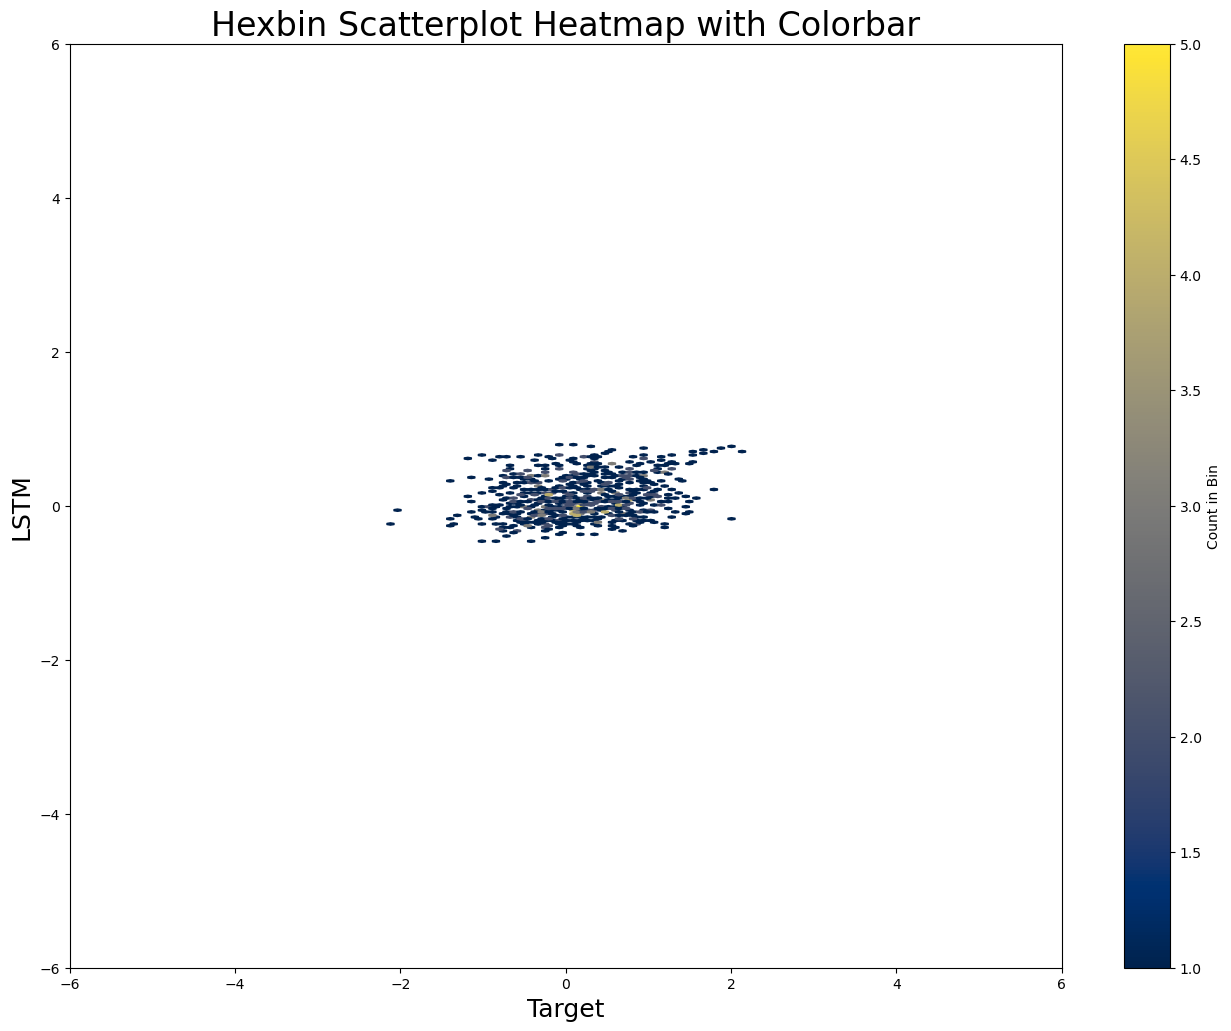

In [197]:
create_hexbin_heatmap(ldf)

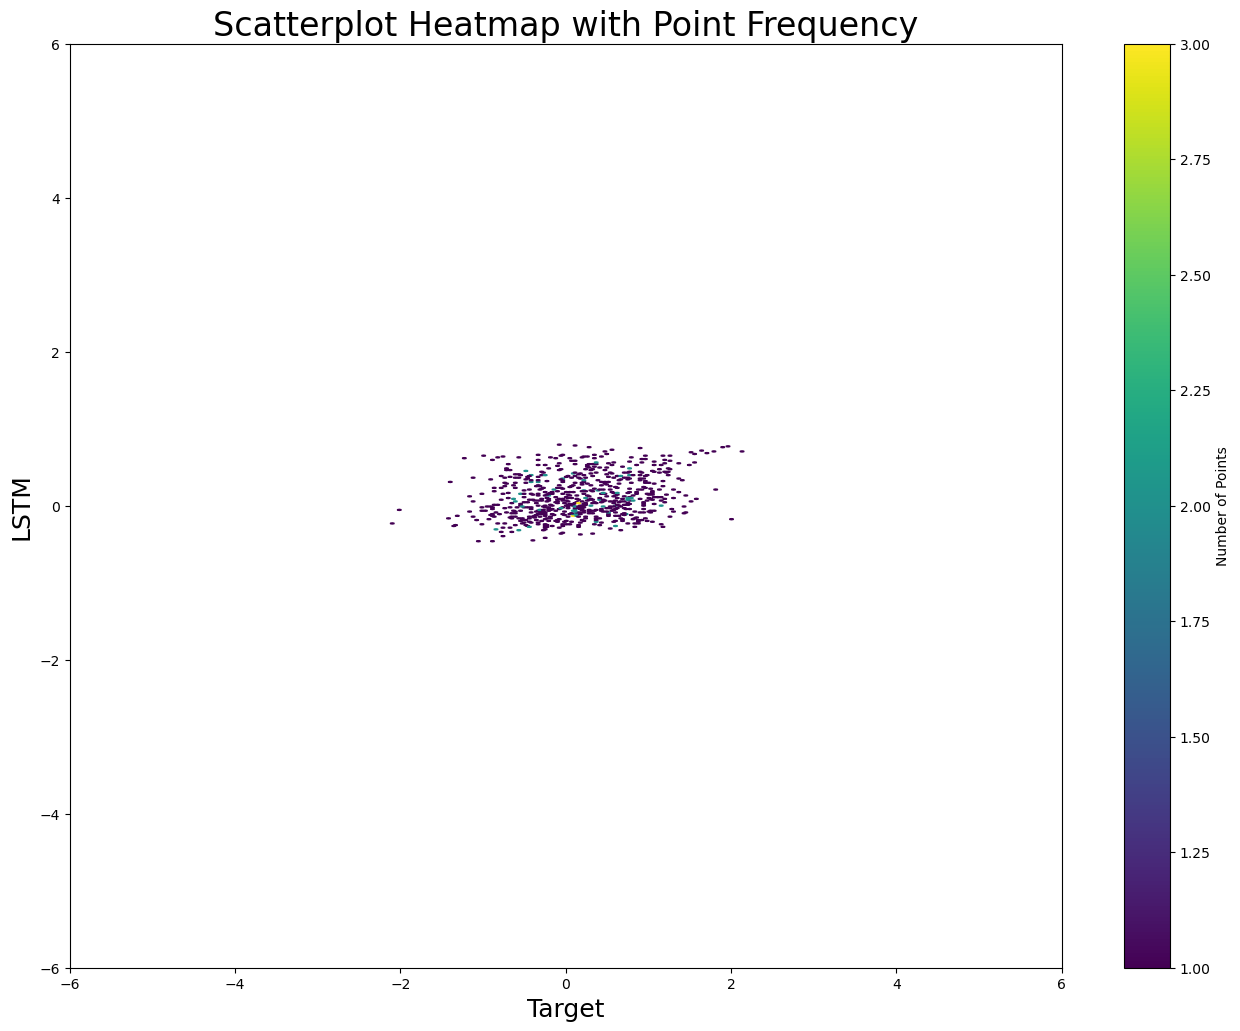

In [198]:
create_scatterplot_heatmap(ldf)

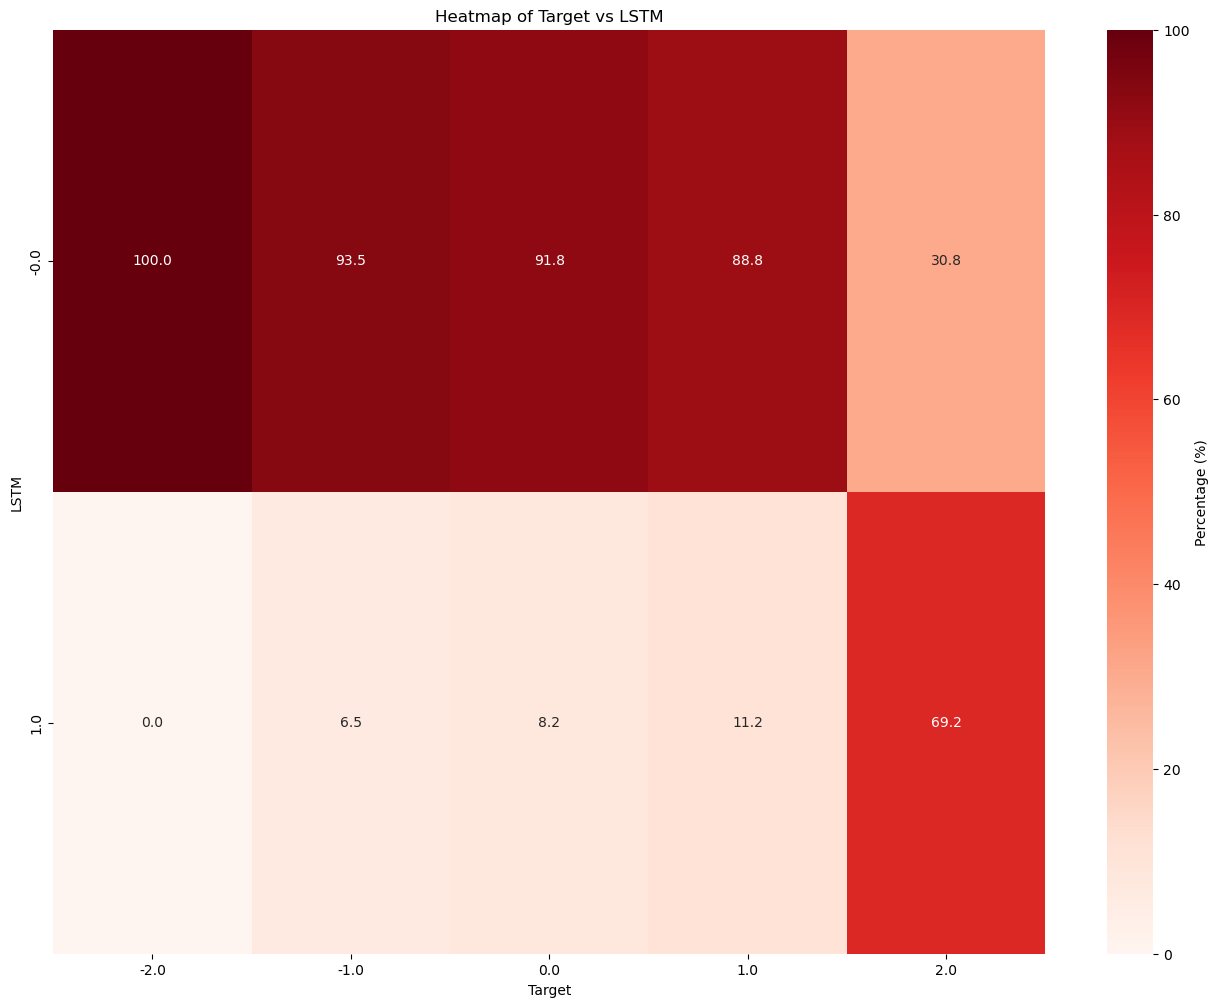

In [199]:
create_heatmap(ldf)

/tmp/tmp.bOfdhcUGZS/ipykernel_2631895/2351311710.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022, 2023])


ZeroDivisionError: division by zero

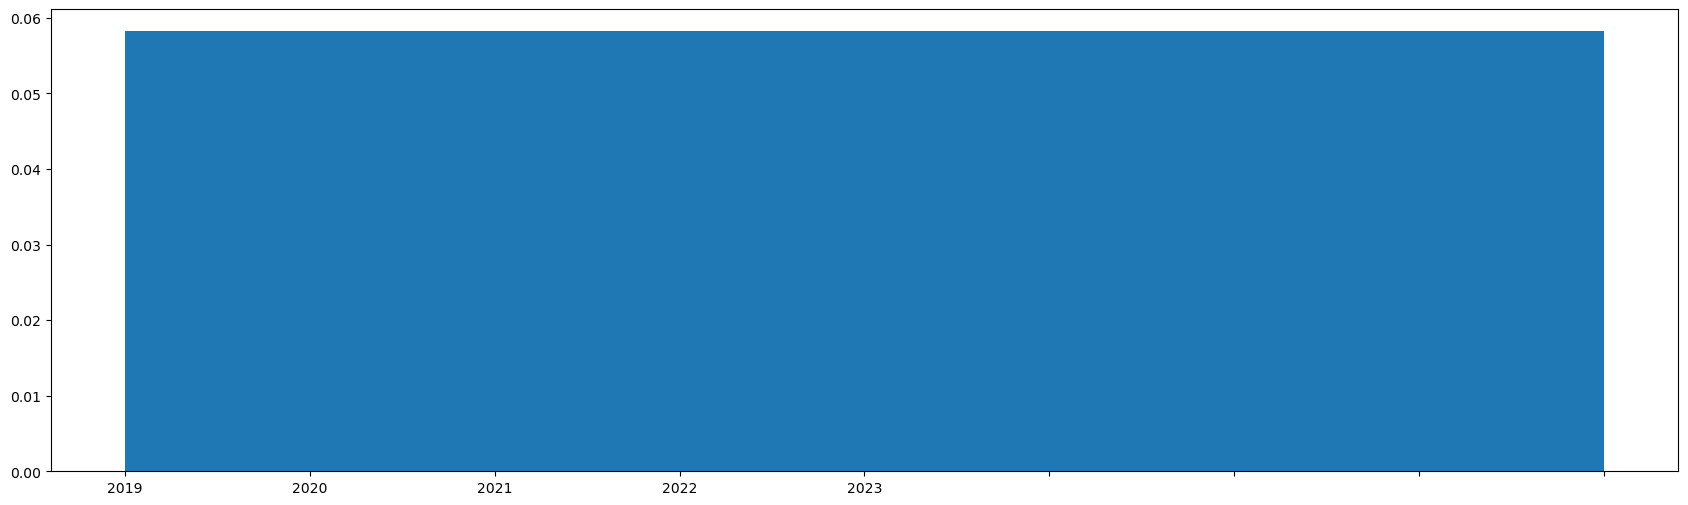

In [200]:
err_by_month = groupby_month(ldf, "diff")

In [ ]:
def groupby_time(df, col):
    df = df[df[col] > -999]
    GB = df.groupby([(df.valid_time.dt.hour)])[col].mean()
    the_list = GB.tolist()
    fig, ax = plt.subplots(figsize=(21, 6))
    x = np.arange(0, len(the_list))
    plt.bar(x, the_list, color="g")
    return the_list

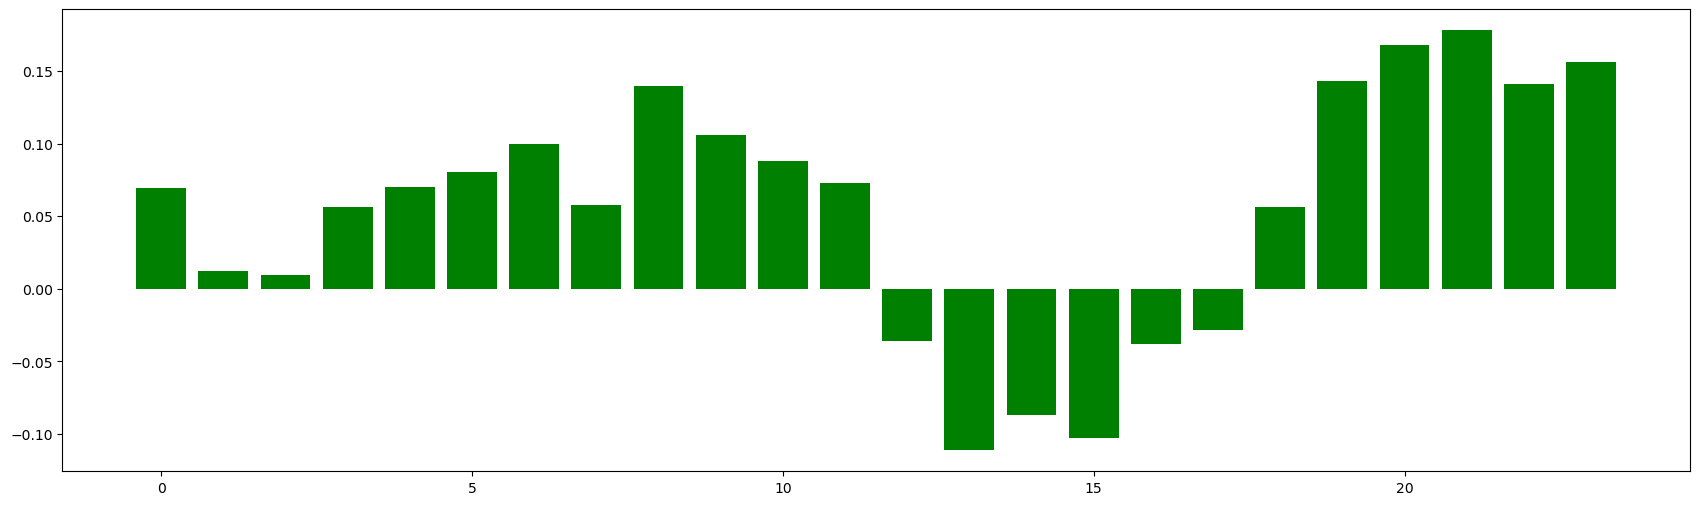

In [ ]:
err_by_time = groupby_time(ldf, "diff")

In [ ]:
import calendar


def groupby_month_total(df, col):
    df = df[df[col] > -999]
    GB = df.groupby([(df.valid_time.dt.month)])[col].mean()
    the_list = GB.tolist()
    fig, ax = plt.subplots(figsize=(21, 6))
    x = np.arange(0, len(the_list))

    # Get a colormap
    cmap = plt.get_cmap("RdBu")
    # Normalize your data to map to the colormap
    norm = plt.Normalize(min(the_list), max(the_list))
    colors = cmap(norm(the_list))

    # Create a bar chart
    plt.bar(x, the_list, color=colors)
    ax.set_xticks(x)  # Set x-ticks to be at the positions of the months
    month_labels = [calendar.month_name[month] for month in GB.index]
    ax.set_xticklabels(month_labels)  # Label x-ticks with month numbers

    plt.show()
    return the_list

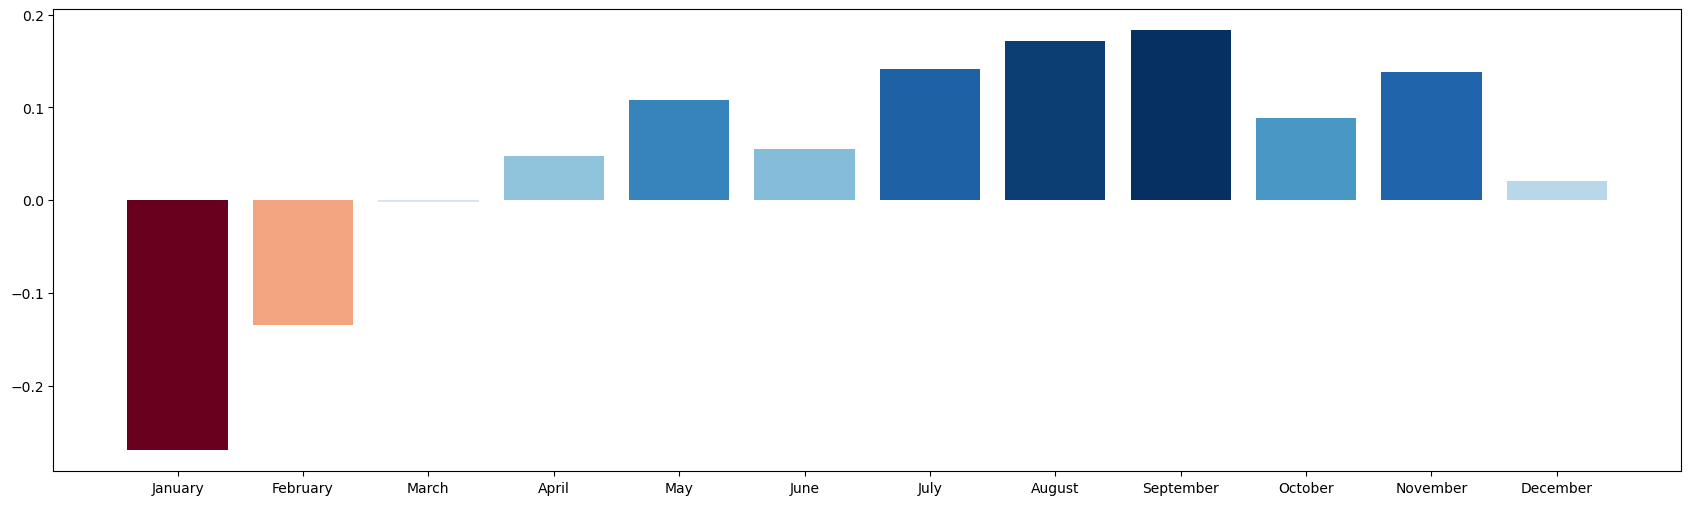

[-0.26975059509277344,
 -0.13486450910568237,
 -0.0017232593381777406,
 0.047585465013980865,
 0.10838267207145691,
 0.05542908236384392,
 0.14192837476730347,
 0.17142847180366516,
 0.1831713765859604,
 0.08872999995946884,
 0.13771681487560272,
 0.02029344066977501]

In [ ]:
groupby_month_total(ldf, "diff")

In [ ]:
def myround(x, base):
    return base * round(x / base)

In [ ]:
# function to get unique values
def unique(list1):
    # initialize a null list
    unique_list = []

    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

In [ ]:
def err_bucket(full_df, met_col, rounded_base):
    temps = []
    for i, _ in enumerate(full_df[met_col]):
        rounded = myround(full_df[met_col].iloc[i], rounded_base)
        temps.append(rounded)

    unique_temps = unique(temps)

    zeros = np.zeros(len(unique_temps))
    rs = np.resize(zeros, (len(unique_temps), len(unique_temps)))

    temp_df = pd.DataFrame(
        data=rs, index=[np.arange(len(unique_temps))], columns=sorted(unique_temps)
    )

    for i, _ in enumerate(full_df[met_col]):
        rounded = myround(full_df[met_col].iloc[i], rounded_base)
        err = full_df["Abs_err"].iloc[i]
        temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
        temp_df[rounded].iloc[-1] += 1

    instances = temp_df.iloc[-1]
    temp_df = temp_df.iloc[0]

    return temp_df, instances

In [ ]:
def plot_buckets(temp_df, instances, var_name, cmap, width):
    my_cmap = plt.get_cmap(cmap)
    averages = temp_df / instances
    y = averages
    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
    the_list = averages.tolist()
    fig, ax = plt.subplots(
        figsize=(21, 6), facecolor="slategrey", constrained_layout=True
    )
    bars = plt.bar(temp_df.keys(), the_list, color=my_cmap(rescale(y)), width=width)
    ax.set_title("Absolute Error of LSTM", fontsize=28, c="white")
    ax.set_xlabel(var_name, fontsize=18, c="white")
    ax.set_ylabel("Mean Absolute Error", fontsize=18, c="white")
    # Iterating over the bars one-by-one
    # Annotate each bar with its value
    # Annotate each bar with the number of instances
    for bar, value, instance_count in zip(bars, the_list, instances):
        yval = value + 0.01  # Adjust the vertical position of the label
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"n={instance_count}",
            ha="center",
            va="bottom",
            color="black",
            fontsize=12,
            rotation=90,
        )

In [ ]:
# for k in full_df.keys():
#     print(k)

In [ ]:
# diector = sorted(os.listdir('/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20231129/'))

# for d in diector:
#         full_df = pd.read_parquet(
#         f"/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20231129/{d}"
#     )
#         for k in full_df.columns:
#             if re.search(
#                 f"{station}",
#                 k,
#             ):
#                 print("Succes!!")
#                 print(d)
#             else:
#                 continue

In [ ]:
# Reset index for both DataFrames to ensure alignment
full_df = full_df.reset_index(drop=True)
ldf = ldf.reset_index(drop=True)
full_df["Abs_err"] = ldf["diff"]

In [ ]:
full_df.dropna(inplace=True)

In [ ]:
temp_df, instances = err_bucket(full_df, f"tair_{station}", 2)

/tmp/tmp.bOfdhcUGZS/ipykernel_1014372/1558746766.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
/tmp/tmp.bOfdhcUGZS/ipykernel_1014372/1558746766.py:20: FutureWarning: 

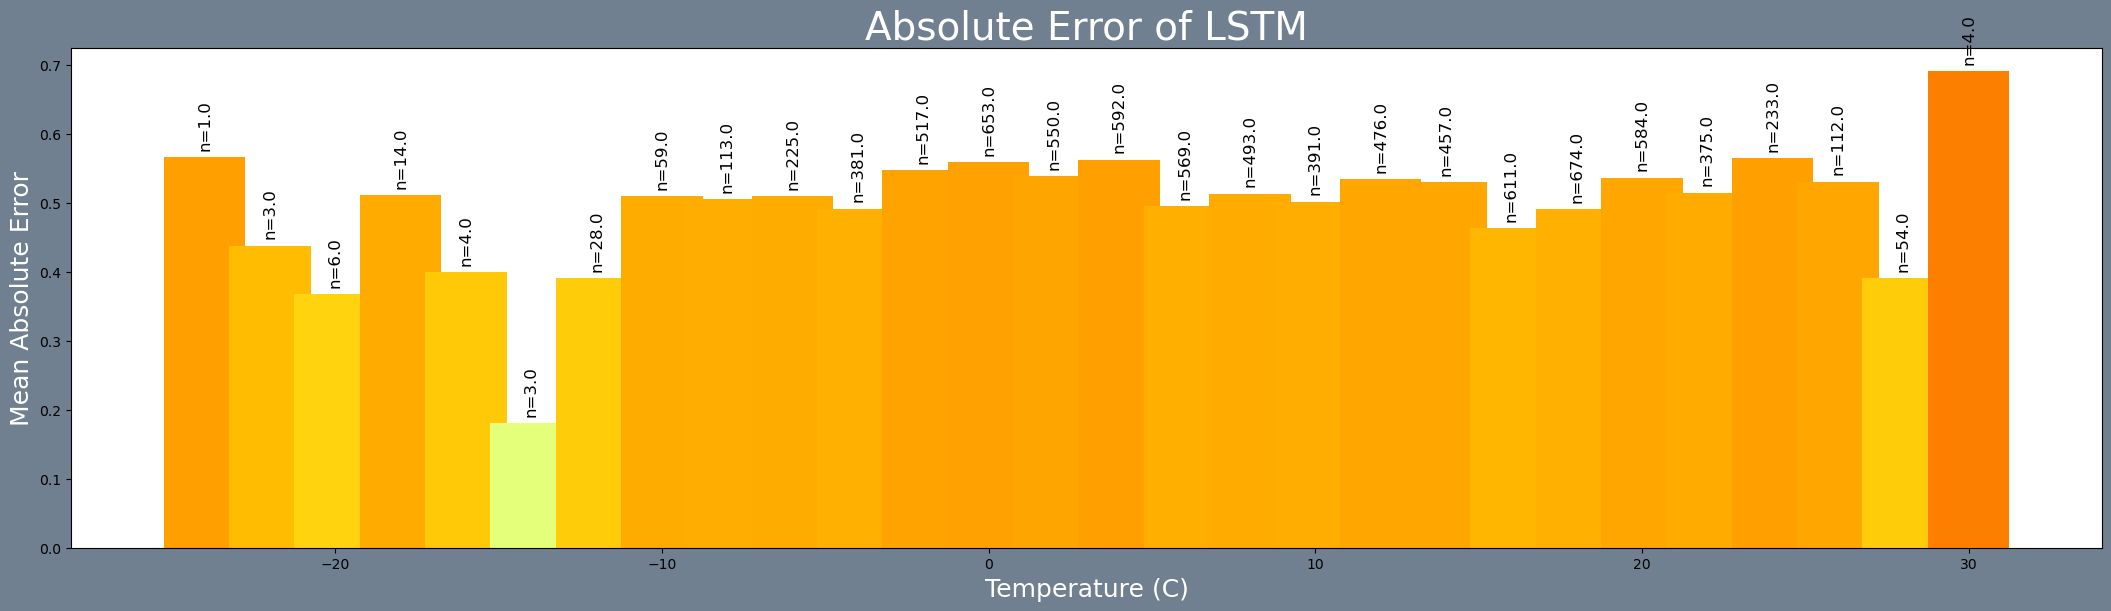

In [ ]:
plot_buckets(temp_df, instances, "Temperature (C)", "Wistia", 2.5)

In [ ]:
relh_df, instances = err_bucket(full_df, f"relh_{station}", 2)

/tmp/tmp.bOfdhcUGZS/ipykernel_1014372/1558746766.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
/tmp/tmp.bOfdhcUGZS/ipykernel_1014372/1558746766.py:20: FutureWarning: 

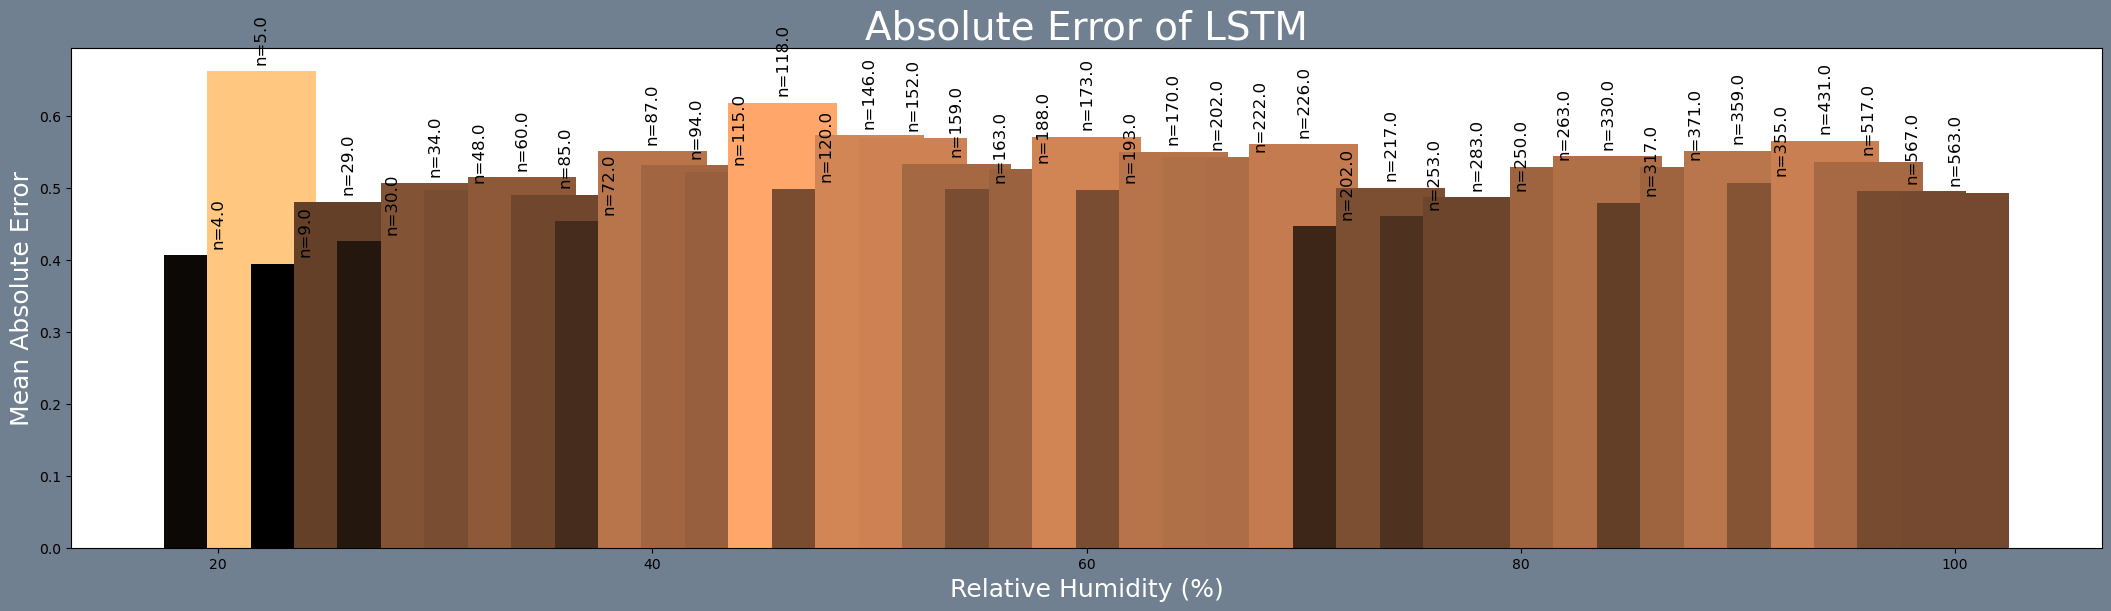

In [ ]:
plot_buckets(relh_df, instances, "Relative Humidity (%)", "copper", 5.0)

In [ ]:
new_df, instances = err_bucket(full_df, f"srad_{station}", 40)

/tmp/tmp.bOfdhcUGZS/ipykernel_1014372/1558746766.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
/tmp/tmp.bOfdhcUGZS/ipykernel_1014372/1558746766.py:20: FutureWarning: 

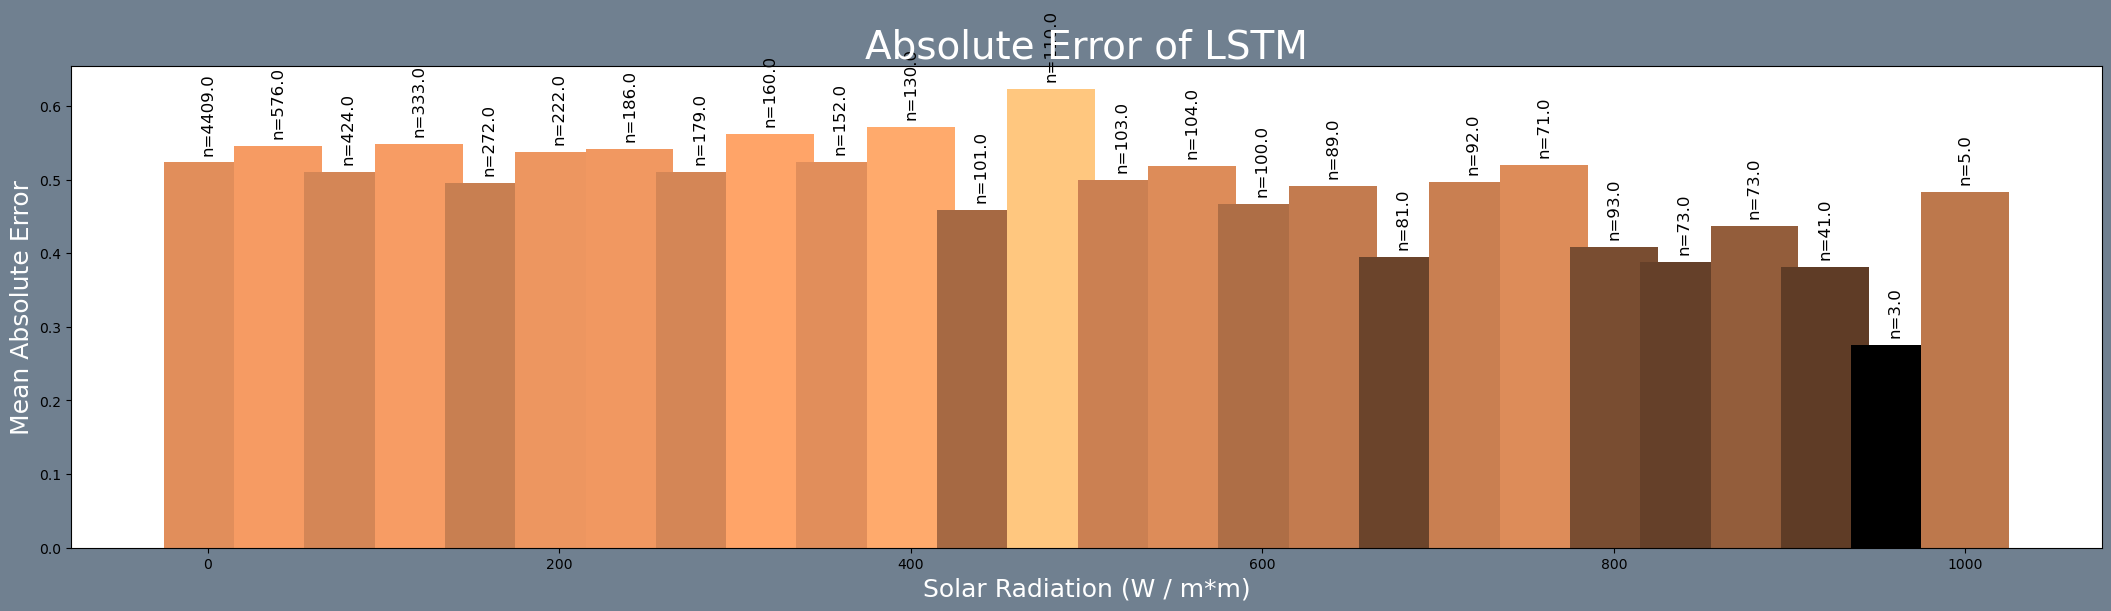

In [ ]:
plot_buckets(new_df, instances, "Solar Radiation (W / m*m)", "copper", 50.0)

In [ ]:
pres_df, instances = err_bucket(full_df, f"pres_{station}", 2)

/tmp/tmp.bOfdhcUGZS/ipykernel_1014372/1558746766.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
/tmp/tmp.bOfdhcUGZS/ipykernel_1014372/1558746766.py:20: FutureWarning: 

In [ ]:
print(f'The mean pressure at {station} is {full_df[f"pres_{station}"].mean()}')

The mean pressure at WARS is 951.8065795898438


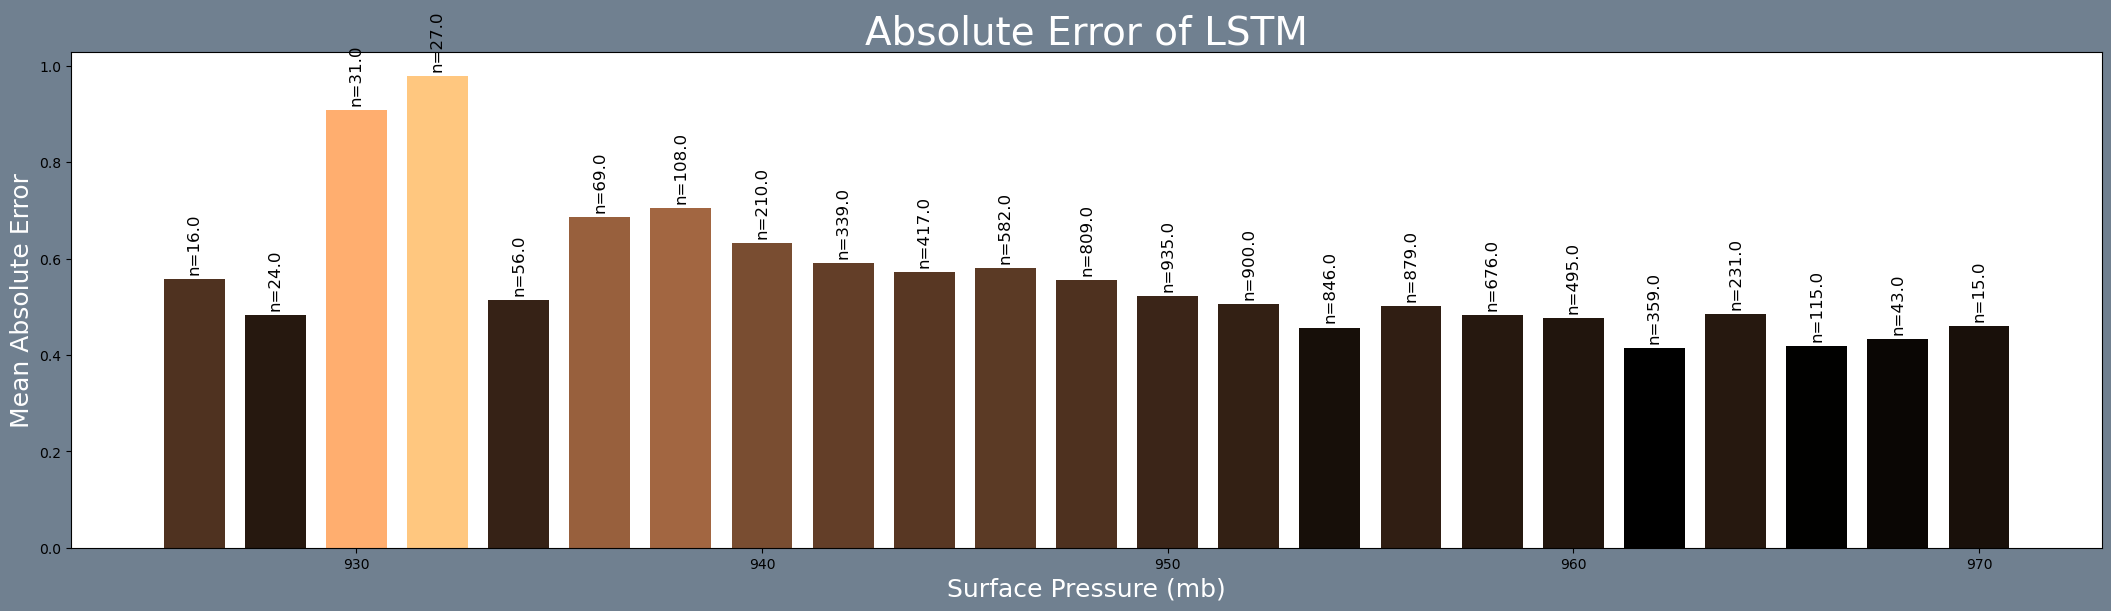

In [ ]:
plot_buckets(pres_df, instances, "Surface Pressure (mb)", "copper", 1.5)

In [ ]:
def round_small(full_df, met_col, rounded_base):
    temps = []
    for i, _ in enumerate(full_df[met_col]):
        if full_df[met_col].iloc[i] < 1.0 and full_df[met_col].iloc[i] >= 0:
            rounded = round(full_df[met_col].iloc[i], rounded_base)
            temps.append(rounded)
        else:
            rounded = myround(full_df[met_col].iloc[i], 1)
            temps.append(rounded)

    unique_temps = unique(temps)

    zeros = np.zeros(len(unique_temps))
    rs = np.resize(zeros, (len(unique_temps), len(unique_temps)))
    temp_df = pd.DataFrame(
        data=rs, index=[np.arange(len(unique_temps))], columns=sorted(unique_temps)
    )

    for i, _ in enumerate(full_df[met_col]):
        if full_df[met_col].iloc[i] < 1.0 and full_df[met_col].iloc[i] >= 0:
            rounded = round(full_df[met_col].iloc[i], rounded_base)
        else:
            rounded = float(myround(full_df[met_col].iloc[i], base=1))
        err = float(full_df["Abs_err"].iloc[i])
        temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
        temp_df[rounded].iloc[-1] += 1

    instances = temp_df.iloc[-1]
    temp_df = temp_df.iloc[0]
    temp_df = temp_df.loc[~(temp_df == 0)]
    instances = instances.loc[~(instances == 0)]
    return temp_df, instances

In [ ]:
rain_df, instances = err_bucket(full_df, f"precip_total_{station}", 0.1)

/tmp/tmp.bOfdhcUGZS/ipykernel_1014372/1558746766.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
/tmp/tmp.bOfdhcUGZS/ipykernel_1014372/1558746766.py:20: FutureWarning: 

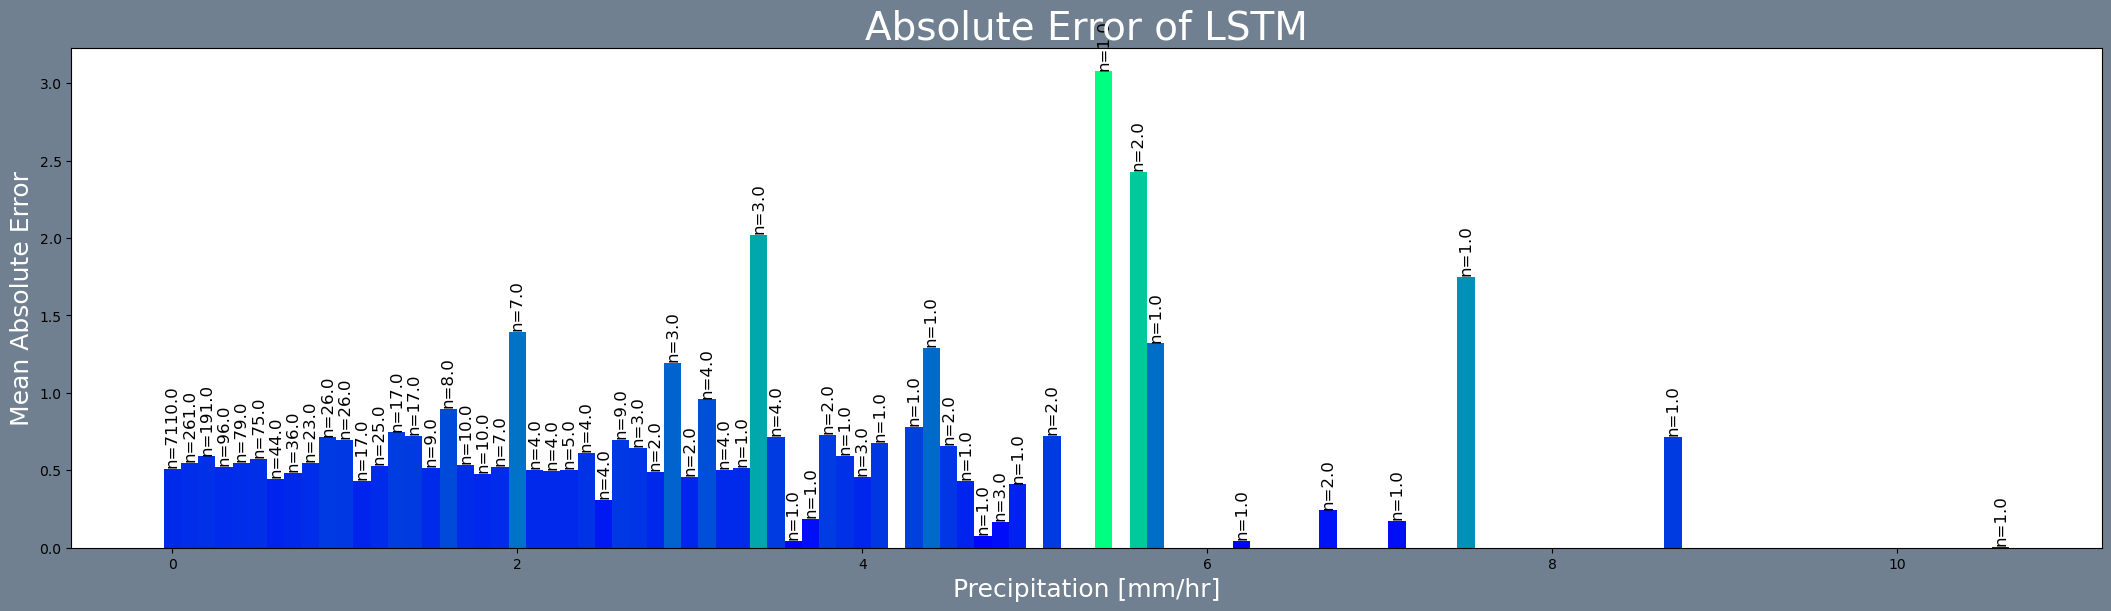

In [ ]:
plot_buckets(rain_df, instances, "Precipitation [mm/hr]", "winter", 0.1)

In [ ]:
snow_df, instances = round_small(full_df, f"snow_depth_{station}", 2)

/tmp/tmp.bOfdhcUGZS/ipykernel_1014372/1323447786.py:25: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
/tmp/tmp.bOfdhcUGZS/ipykernel_1014372/1323447786.py:26: FutureWarning: 

In [ ]:
snow_df = snow_df.iloc[1:]
instances = instances.iloc[1:]

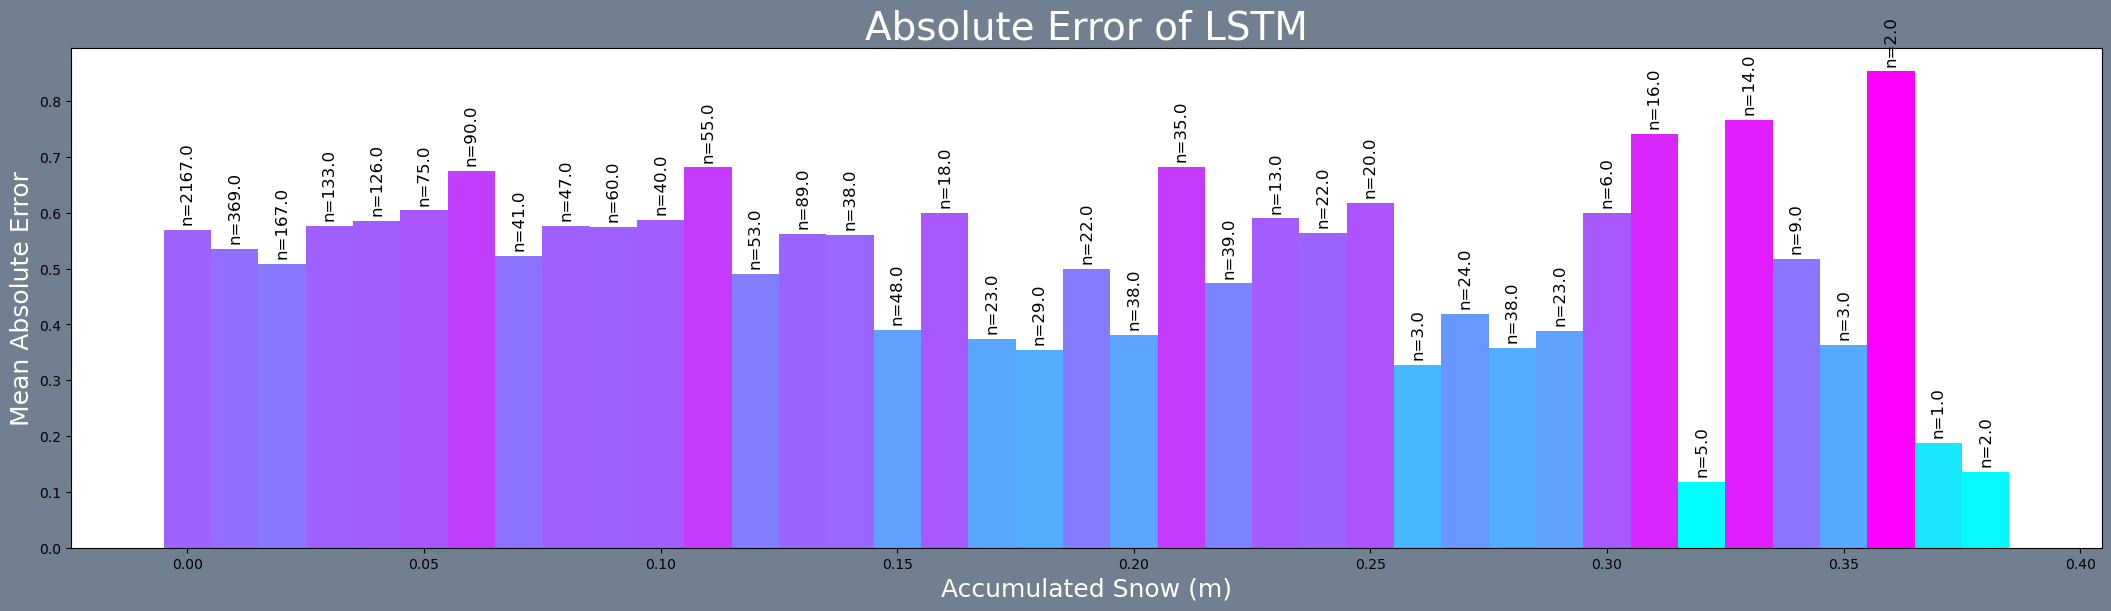

In [ ]:
plot_buckets(snow_df, instances, "Accumulated Snow (m)", "cool", 0.01)

In [ ]:
wmax, instances = err_bucket(full_df, f"wmax_sonic_{station}", 2)

/tmp/tmp.bOfdhcUGZS/ipykernel_1014372/1558746766.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
/tmp/tmp.bOfdhcUGZS/ipykernel_1014372/1558746766.py:20: FutureWarning: 

Hello camera man


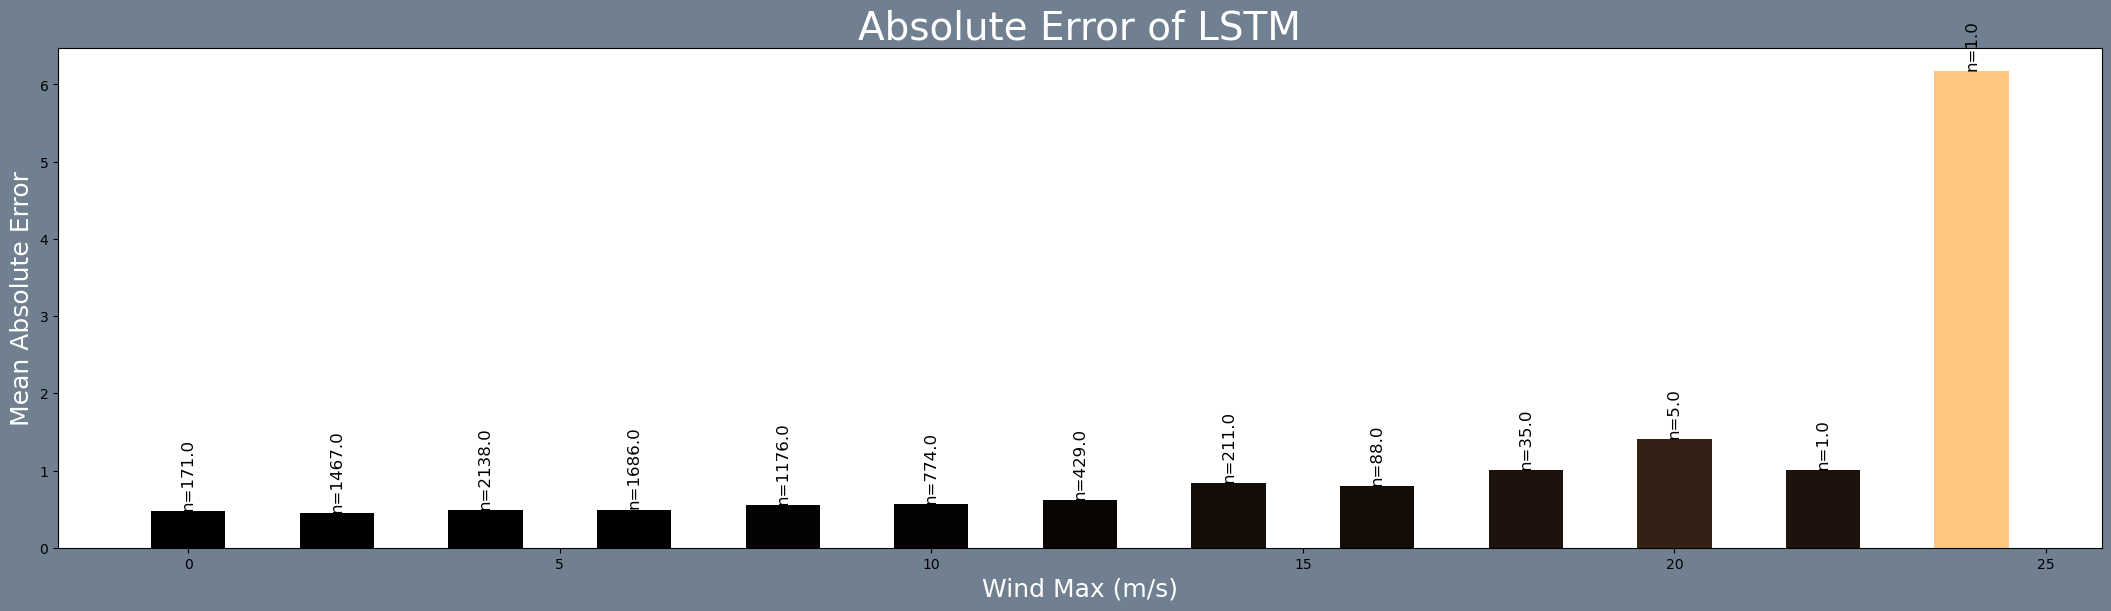

In [ ]:
plot_buckets(wmax, instances, "Wind Max (m/s)", "copper", 1.0)
print("Hello camera man")

In [ ]:
wdir, instances = err_bucket(full_df, f"wdir_sonic_{station}", 45)

/tmp/tmp.bOfdhcUGZS/ipykernel_1014372/1558746766.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  temp_df[rounded].iloc[0] = abs(err) + abs(temp_df[rounded].iloc[0])
/tmp/tmp.bOfdhcUGZS/ipykernel_1014372/1558746766.py:20: FutureWarning: 

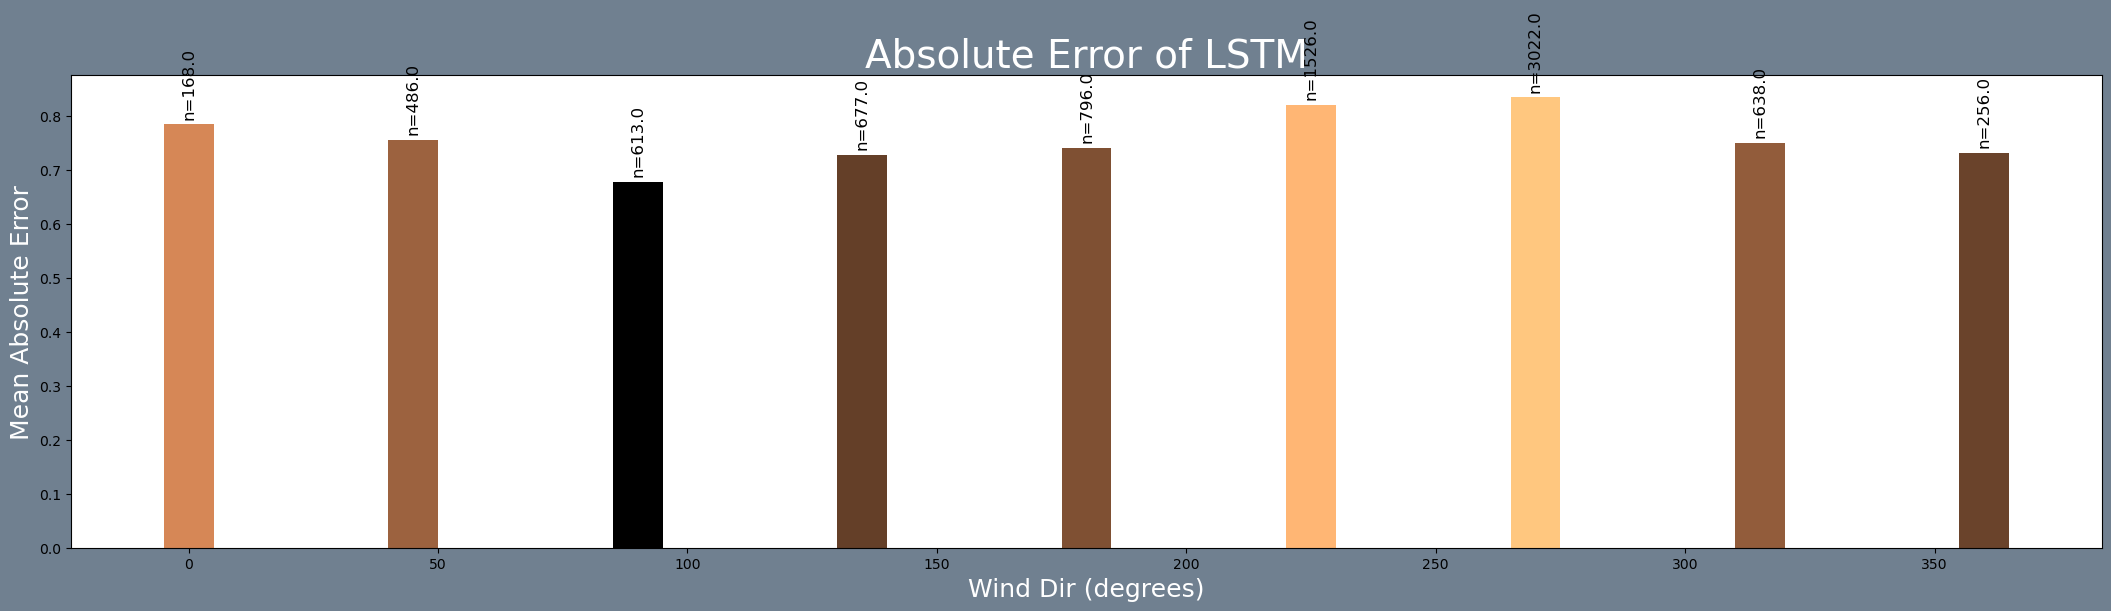

In [ ]:
plot_buckets(wdir, instances, "Wind Dir (degrees)", "copper", 10.0)